<a href="https://github.com/seth-mc/sethsgit"><img src= "https://i.ibb.co/WtQWBMc/sethlogo.png" alt="sethlogo" border="0" width = 150 align = left></a>

# Capstone Project

## I. Introduction

<p>Victoria in British Columbia is one of Canada's most beautiful destinations on the West Coast. As a hub for University students, I strive to thoroughly examine the neighbourhoods within Victoria, and decide which area of the island has the most to offer. The following report will use FourSquare's API to cluster together venues in Victoria based on neighbourhoods. I will then look at the clustered dataset to decide which area in Victoria people should check out.</p>

<p>Target Audience: this report is aimed towards students who frequent the island on the West coast, and are looking to find more around their home.</p><p>Data Used: A ranked table of the all of Victoria's neighbourhoods, and FourSquare's API. </p>
<p>Victoria is segregated into the 164 neighbourhoods, and <a href="https://www.moneysense.ca/spend/real-estate/victoria-real-estate-full-neighbourhood-ranking/"> moneysense.ca</a> has ranked them for me. </p> 

## II. Methodology

<p> In the following, I will use Python code and data analysis techniques to decide which area of the island is the best to see. I will break down my process into the following sections:</p>
<ol type="I">
    <li>I will extract the table from moneysense.ca into a <em>pandas</em> dataframe: one of Python's modules for creating and organizing various datasets.</li>
    <li>I will get the coordinates for each neighbourhood, and make a new dataframe with Latitude and Longitude columns.</li>
    <li>How can we use machine learning? We will use an unsupervised methodology to organize our data (<em>unsupervised learning</em>: when we allow the computer to find trends within the data without any help from the person behind the computer). I will show why <em>K</em>-means clustering does not work for our dataset, then use DBSCAN to properly organize our data and get rid of outliers. </li>
    <li>After our data has be clustered, I will then use FourSquare's API to find venues within each neighbourhood of Victoria.</li>
    <li>Once venues have been found, I will find the frequency of each venue, and put the neighbourhoods into the groups I clustered earlier.</li>
    <li>Lastly, I will compare the original dataset from moneysense.ca to the one I created, and decide which neighbourhoods are worthwhile to check out.</li>
    </ol>

## Imports

In [27]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import itertools
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
%matplotlib inline

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
from sklearn import preprocessing


# !conda install -c conda-forge folium=0.5.0 --yes
import folium

# !conda install -c conda-forge geocoder --yes
import geocoder

# !conda install -c conda-forge lxml --yes
import lxml

# !conda install -c conda-forge bs4 --yes
from bs4 import BeautifulSoup

import urllib.request
from urllib.request import urlopen

print('Libraries imported.')

Libraries imported.


<p>  </p>
<p>Let's start by extracting the table into a pandas dataframe.</p>
<p>  </p>


In [2]:
# opening the url (and pretending I'm an acual browser!)
url = 'https://www.moneysense.ca/spend/real-estate/victoria-real-estate-full-neighbourhood-ranking/'
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

dfs = pd.read_html(r.text)
msdf = dfs[0]
msdf.head(10)


,Rank,Neighbourhood,Area,Average price,Average price vs. area,Average price vs. metro district,Average price vs. greater city area,Value,1-year price change,3-year price change,5-year price change,Momentum,Realtor grade
0,1,Sidney South-East,Sidney,"$674,253",N.A.,N.A.,89.4%,NaN,24.30%,40.10%,28.0%,NaN,★★★★½
1,2,Saxe Point,Esquimalt,"$618,365",N.A.,N.A.,81.9%,NaN,14.03%,33.29%,27.7%,NaN,★★★★½
2,3,Sidney North-East,Sidney,"$674,253",N.A.,N.A.,89.4%,NaN,24.30%,40.10%,28.0%,NaN,★★★★
3,4,Whiffin Spit,Sooke,"$475,935",N.A.,N.A.,63.1%,NaN,13.25%,16.77%,15.7%,NaN,★★★★
4,5,Fairfield East,Victoria,"$801,513",N.A.,N.A.,106.2%,NaN,22.97%,32.82%,31.1%,NaN,★★★★★
5,5,Fairfield West,Victoria,"$801,513",N.A.,N.A.,106.2%,NaN,22.97%,32.82%,31.1%,NaN,★★★★★
6,7,Rockland,Victoria,"$801,513",N.A.,N.A.,106.2%,NaN,22.97%,32.82%,31.1%,NaN,★★★★½
7,8,James Bay,Victoria,"$801,513",N.A.,N.A.,106.2%,NaN,22.97%,32.82%,31.1%,NaN,★★★★½
8,9,Sidney South-West,Sidney,"$674,253",N.A.,N.A.,89.4%,NaN,24.30%,40.10%,28.0%,NaN,★★★★
9,10,Sunriver,Sooke,"$475,935",N.A.,N.A.,63.1%,NaN,13.25%,16.77%,15.7%,NaN,★★★★


<p>Now let's add the coordinates:</p>

In [3]:
neighbourhoods = msdf['Neighbourhood']

coords = [(48.6489372253418, -123.40031433105469),  (48.4219481, -123.4201646),  (48.6489372253418, -123.40031433105469),  (48.3590024, -123.7145659),  (48.4136422, -123.3505772),  (48.4136422, -123.3505772),  (48.42142868041992, -123.34114837646484),  (48.41529846191406, -123.37712097167969),  (48.6505788, -123.3983246),  (48.39333724975586, -123.7119140625),  (49.215824127197266, -124.01290130615234),  (48.4486749, -123.3672669),  (48.44964, -123.3026),  (48.42573928833008, -123.36554718017578),  (48.4339714050293, -123.38616180419922),  (48.4234135, -123.4939645),  (48.4028914, -123.4939165),  (48.43293, -123.48591),  (48.6489372253418, -123.40031433105469),  (48.4129877, -123.5234668),  (48.4589958190918, -123.28060150146484),  (48.43294, -123.3693),  (48.43294, -123.3693),  (48.4170505, -123.3283051),  (48.436500549316406, -123.3095703125),  (48.38744354248047, -123.73155212402344),  (48.6176888, -123.4250284),  (48.43294, -123.3693),  (48.44465255737305, -123.40294647216797),  (48.4608549, -123.2969926),  (48.45062255859375, -123.31938934326172),  (48.4295468, -123.4585563),  (49.642743, -125.125443),  (48.441558837890625, -123.40327453613281),  (48.434959411621094, -123.41134643554688),  (50.6895899, -120.3636468),  (50.6895899, -120.3636468),  (48.4973643, -123.3729169),  (48.43294, -123.3693),  (48.3496208190918, -123.81932830810547),  (48.4597302, -123.6160371),  (49.215824127197266, -124.01290130615234),  (48.4427954, -123.5328715),  (53.9754632, -131.7498229),  (48.48689651489258, -123.38832092285156),  (48.47084045410156, -123.41389465332031),  (48.52531814575195, -123.3683853149414),  (48.4863166809082, -123.31783294677734),  (48.43269348144531, -123.41829681396484),  (48.6364827, -123.469765),  (48.6295038, -123.4086429),  (48.4283182, -123.3649533),  (48.4283182, -123.3649533),  (48.4283182, -123.3649533),  (48.5142625, -124.1221063),  (49.3600357, -122.3281492),  (48.46669387817383, -123.29127502441406),  (48.4339005, -123.3865871), (48.6268854, -123.4712645),  (48.43294, -123.3693),  (48.4421498, -123.4852716),  (48.4352007, -123.473067),  (48.50650405883789, -123.36068725585938),  (48.3779818, -123.6915067),  (48.34364318847656, -123.67723083496094),  (48.6748136, -123.3966987),  (48.4493145, -123.5305957),  (48.47097396850586, -123.3707275390625),  (48.42938232421875, -123.3998031616211),  (48.449684143066406, -123.34420776367188),  (48.43301773071289, -123.32747650146484),  (48.43301773071289, -123.52230072021484),  (48.472389221191406, -123.3895263671875),  (48.45783996582031, -123.4776611328125),  (48.3948081, -123.6269994),  (49.6945194, -125.630512),  (48.3754289, -123.851353),  (48.4581184387207, -123.32389831542969),  (48.44087600708008, -123.33806610107422),  (48.47823715209961, -123.33876037597656),  (49.2177644, -124.0273466),  (48.437819, -123.5228697),  (48.4427490234375, -123.47061157226562),  (48.43294, -123.3693),  (50.0873366, -125.0150789),  (49.7030794, -123.1378616),  (48.4577847, -123.4157007),  (49.3113755, -123.0169609),  (48.32951354980469, -123.63306427001953),  (48.390750885009766, -123.94171142578125),  (48.3923972, -123.6746922),  (48.640217, -123.429027),  (48.43294, -123.3693),  (48.4657166, -123.3883823),  (48.43294, -123.3693),  (48.43294, -123.3693),  (48.4917946, -123.3530271),  (48.4247104, -123.5169623),  (48.4914955, -123.4106593),  (48.48652648925781, -123.39765930175781),  (48.457272,  -123.552932),  (49.2832289, -123.1160432),  (48.442549, -123.357023),  (48.47954177856445, -123.33079528808594),  (48.5155813, -123.7012814),  (49.327848, -123.1197444),  (48.43294, -123.3693),  (48.4283182, -123.3649533),  (48.48173522949219, -123.41377258300781),  (48.6882677, -123.4122985),  (48.4469629, -123.3345613),  (48.4594315, -123.3764946),  (48.45835494995117, -123.37702178955078),  (48.4507639, -123.3811156),  (49.2318319, -122.8234237),  (48.4385514, -123.5126449),  (48.5622741, -123.4923272),  (48.4476919, -123.4791339),  (48.550251, -124.417419),  (48.3774241, -123.9229254),  (48.3505511, -123.7110944),  (49.281645, -122.7820644),  (48.5972157, -123.4182151),  (48.442549, -123.357023),  (48.4236552, -123.3038632),  (48.4497693, -123.5046662),  (48.54756546020508, -123.42617797851562),  (48.56336212158203, -123.39997863769531),  (48.53395080566406, -123.01678466796875),  (48.5995262, -123.389904),  (48.4307125, -123.5306974),  (48.45198440551758, -123.39322662353516),  (48.4329878, -123.3569144),  (49.0475163, -122.3110235),  (50.8271508, -126.6692912),  (48.440138, -123.3717323),  (50.2399218, -119.2034433),  (48.4486749, -123.3672669),  (48.476057,  -123.467411),  (48.4312336, -123.4382207),  (49.313581, -122.735166),  (48.3884186, -123.4779704),  (48.3796009, -123.5352348),  (48.4500932, -123.4286468),  (48.3926663, -123.5988023),  (48.406504, -123.5514896),  (48.347747802734375, -123.57257843017578),  (49.279510498046875, -122.84942626953125),  (48.3427514, -123.5276323),  (48.3789783, -123.7812058),  (48.683708, -123.600311),  (48.87810516357422, -123.31857299804688),  (48.9361667, -123.4674678),  (48.5236025, -123.9370765),  (48.43294, -123.3693),  (48.8443829, -123.2875518),  (48.6498511, -123.5527037),  (48.7154627, -123.3084053),  (48.7786931, -123.2816111),  (48.7050638, -123.4171425),  (48.8294892, -123.3740085),  (48.8296672, -123.5151614),  (48.7883689, -123.1479155),  (48.6538128, -123.6229791),  (48.61605, -123.3118168)]

latlon = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

df = latlon.merge(neighbourhoods.to_frame(), left_index=True, right_index=True)
cols = ['Neighbourhood', 'Latitude', 'Longitude']
df = df[cols]
df.tail(10)

,Neighbourhood,Latitude,Longitude
155,Mill Bay,48.844383,-123.287552
156,Moresby Island,48.649851,-123.552704
157,Pender Island,48.715463,-123.308405
158,Piers Island,48.778693,-123.281611
159,Prevost Island,48.705064,-123.417142
160,Salt Spring Island,48.829489,-123.374009
161,Saturna Island,48.829667,-123.515161
162,Shawnigan Lake,48.788369,-123.147915
163,Sidney Island,48.653813,-123.622979
164,View Royal,48.616050,-123.311817


<p>(I was struggling with Geocoder & Google's API (because they limit your calls), so I made a Python GUI to click and grab the coordinates from <a href=https://www.gps-coordinates.net/>GPSCoordinates.net</a>).</p>

<p> OK - I got all the coordinates. But 164 seems like a lot, doesn't it? Let's cluster it into groups. </p>

<p>If you look at the result of our <em>k</em>-means clustering, you will find that that we have outliers in our dataset, and it is throwing off our clustering. Since k-nearest neighbours did not work as well as anticipated, I want to try and cluster our data using DBSCN (Density-Based Clustering).</p>

### Imports

In [4]:
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 

### Choosing epsilon, minimum samples, and data:

In [5]:
coords = df[['Latitude', 'Longitude']]
mms = MinMaxScaler()
mms.fit(coords)
data_scaled = mms.transform(coords)

In [6]:
epsilon = 0.2
minimumSamples = 6
X = data_scaled

db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)

labels = db.labels_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [7]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### Mapping the Data

In [8]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)

In [9]:
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

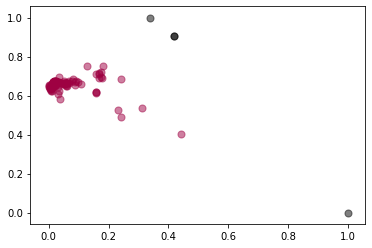

In [10]:
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

In [11]:
groups2 = pd.DataFrame(labels)
df['Group'] = groups2

address = 'Victoria, BC'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

victoriamap = folium.Map(location=[latitude, longitude], tiles='stamenwatercolor', zoom_start=10)

# add markers to map
for lat, lng, group, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Group'], df['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    # plotting the points
    if group == 0:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='#9E0142',  # RED
            fill=True,
            fill_color='#9E0142',  # RED
            fill_opacity=0.7,
            parse_html=False).add_to(victoriamap)  
    if group == 1:
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='#F98E52',  # ORANGE
            fill=True,
            fill_color='#F98E52',  # ORANGE
            fill_opacity=0.7,
            parse_html=False).add_to(victoriamap)
        
victoriamap

<p> Much better selection of the data! DBSCAN noticed that we had outliers, and got rid of them in clustering.</p>

In [12]:
outliernum = [-1]
df_db = df[~df['Group'].isin(outliernum)]
df_db = df_db.drop('Group', axis=1)
df_db.reset_index(drop=True).head(5)

,Neighbourhood,Latitude,Longitude
0,Sidney South-East,48.648937,-123.400314
1,Saxe Point,48.421948,-123.420165
2,Sidney North-East,48.648937,-123.400314
3,Whiffin Spit,48.359002,-123.714566
4,Fairfield East,48.413642,-123.350577


<p> Now that we got the coordinates of the various neighbourhoods in Victoria, let's explore what's near them with the FourSquare API. </p>

In [13]:
# @hidden_cell
CLIENT_ID = 'SCKOJUNEYT5JLNNL3P53QIVOFGXNLJLKO4IUYG5DE4AGSXK5' # your Foursquare ID
CLIENT_SECRET = 'QMKHHDFI4PGA3LWSEWSK2JQ1AA1I01BULB0SBH3N541WA2RB' # your Foursquare Secret
VERSION = '20200626' # Foursquare API version

### Definitions

In [14]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
victoria_venues = getNearbyVenues(names=df_db['Neighbourhood'],
                                   latitudes=df_db['Latitude'],
                                   longitudes=df_db['Longitude']
                                  )

Sidney South-East
Saxe Point
Sidney North-East
Whiffin Spit
Fairfield East
Fairfield West
Rockland
James Bay
Sidney South-West
Sunriver
Uplands
Olympic View
South Oak Bya
Downtown
Songhees
Lagoon
Royal Bay
Bear Mountain
Sidney North-West
Latoria
Ten Mile Point
Ferwood
Bear Mountain
Gonzales
Estevan
Broomhill
Dean Park
Deep Cover
Kinsmen Park
Cadboro Bay
Henderson
Royal Roads
Arbutus
Gorge Vale
Rockheights
Broadmead
John Muir
Otter Point
Lands End
Olympic View
Westhills
Royal Oak
Strawberry Vale
Cordova Bay
Gordon Head
Esquimalt
Ardmore
Bazan Bay
Sun Ridge
Triangle
Beaver Lake
Elk Lake
Florence Lake
Queenswood
Victoria West
Coles Bay
Thetis Heights
Colwood Lake
Hatley Park
Sunnymead
Billings spit
East Sooke
Curteis Point
Langford Lake
West Saanich
Old Esquimalt
Cedar Hill
Jubilee
Glen Lake
Marigold
Mill Hill
17 Mile
Phillips North
West Coast Rd.
Mt. Tolmie
Oaklands
Mt. Doug
Fairway
Happy Valley
Colwood Corners
Wishard North
Gorge
Northridge
Portage Inlet
Maplewood
Becher Bay
French Beac

In [17]:
print(victoria_venues.shape)
victoria_venues.head()

(2093, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Sidney South-East,48.648937,-123.400314,3rd Street Cafe,48.648931,-123.397753,Breakfast Spot
1,Sidney South-East,48.648937,-123.400314,Boondocks,48.649660,-123.400080,Gastropub
2,Sidney South-East,48.648937,-123.400314,Serious Coffee,48.648935,-123.399627,Coffee Shop
3,Sidney South-East,48.648937,-123.400314,The Woodshed,48.649056,-123.401215,Pizza Place
4,Sidney South-East,48.648937,-123.400314,Maria's Souvlaki,48.649290,-123.396575,Greek Restaurant


In [18]:
venuedf = victoria_venues.groupby('Neighbourhood').count()
venuedf.head(5)

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
17 Mile,2,2,2,2,2,2
Airport,12,12,12,12,12,12
Albert Head,1,1,1,1,1,1
Ardmore,1,1,1,1,1,1
Atkins,1,1,1,1,1,1


In [19]:
print('There are {} unique categories.'.format(len(victoria_venues['Venue Category'].unique())))

There are 208 unique categories.


## Analyzing the Neighbourhood

In [20]:
victoria_onehot = pd.get_dummies(victoria_venues[['Venue Category']], prefix="", prefix_sep="")

victoria_onehot['Neighbourhood'] = victoria_venues['Neighbourhood'] 

fixed_columns = [victoria_onehot.columns[-1]] + list(victoria_onehot.columns[:-1])
victoria_onehot = victoria_onehot[fixed_columns]

victoria_grouped = victoria_onehot.groupby('Neighbourhood').mean().reset_index()
victoria_grouped.head(20)

,Neighbourhood,Accessories Store,Airport,Airport Lounge,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Workshop,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Candy Store,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Electronics Store,Event Service,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Gluten-free Restaurant,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Lake,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Physical Therapist,Pie Shop,Pier,Pizza Place,Playground,Plaza,Poke Place,Post Office,Pub,Record Shop,Recreation Center,Rental Car Location,Rental Service,Resort,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo
0,17 Mile,0.0,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.00,0.000000,0.000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.0000,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.00,0.0000,0.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.500000,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0000,0.0,0.000000,0.0,0.00,0.0,0.00,0.0,0.0,0.500000,0.00,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.00,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.00,0.0000,0.000000,0.0,0.0000,0.000000,0.0,0.0,0.0,0.00,0.000000,0

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = victoria_grouped['Neighbourhood']

for ind in np.arange(victoria_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(victoria_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,17 Mile,Pub,Liquor Store,Zoo,Farm,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fishing Spot
1,Airport,Rental Car Location,Airport Terminal,Airport,Coffee Shop,Café,Burger Joint,Airport Lounge,Dog Run,Fish & Chips Shop,French Restaurant
2,Albert Head,Brewery,Department Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fishing Spot
3,Ardmore,Construction & Landscaping,Zoo,Farmers Market,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fishing Spot
4,Atkins,Park,Zoo,Farm,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fishing Spot,Fish Market


<p>Lastly, let's cluster these neighbourhoods using <em>k</em>-means clustering.</p>

### Clustering

In [48]:
kclusters = 5

victoria_grouped_clustering = victoria_grouped.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(victoria_grouped_clustering)
kmeans.labels_[0:10] 

array([0, 0, 0, 3, 1, 0, 0, 0, 0, 0], dtype=int32)

In [50]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_,)
victoria_merged = df_db

victoria_merged = victoria_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

victoria_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Sidney South-East,48.648937,-123.400314,0.0,Coffee Shop,Hotel,Breakfast Spot,Ice Cream Shop,Restaurant,Grocery Store,Greek Restaurant,Shopping Mall,Seafood Restaurant,Bakery
1,Saxe Point,48.421948,-123.420165,2.0,Scenic Lookout,Zoo,Deli / Bodega,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fishing Spot,Fish Market
2,Sidney North-East,48.648937,-123.400314,0.0,Coffee Shop,Hotel,Breakfast Spot,Ice Cream Shop,Restaurant,Grocery Store,Greek Restaurant,Shopping Mall,Seafood Restaurant,Bakery
3,Whiffin Spit,48.359002,-123.714566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fairfield East,48.413642,-123.350577,0.0,Coffee Shop,Grocery Store,Restaurant,Café,Mexican Restaurant,Convenience Store,Pub,Sandwich Place,Butcher,Flea Market


In [59]:
victoria_merged = victoria_merged[pd.notnull(victoria_merged['Cluster Labels'])]
victoria_merged['Cluster Labels'].astype(int)
victoria_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Sidney South-East,48.648937,-123.400314,0.0,Coffee Shop,Hotel,Breakfast Spot,Ice Cream Shop,Restaurant,Grocery Store,Greek Restaurant,Shopping Mall,Seafood Restaurant,Bakery
1,Saxe Point,48.421948,-123.420165,2.0,Scenic Lookout,Zoo,Deli / Bodega,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Fishing Spot,Fish Market
2,Sidney North-East,48.648937,-123.400314,0.0,Coffee Shop,Hotel,Breakfast Spot,Ice Cream Shop,Restaurant,Grocery Store,Greek Restaurant,Shopping Mall,Seafood Restaurant,Bakery
4,Fairfield East,48.413642,-123.350577,0.0,Coffee Shop,Grocery Store,Restaurant,Café,Mexican Restaurant,Convenience Store,Pub,Sandwich Place,Butcher,Flea Market
5,Fairfield West,48.413642,-123.350577,0.0,Coffee Shop,Grocery Store,Restaurant,Café,Mexican Restaurant,Convenience Store,Pub,Sandwich Place,Butcher,Flea Market


In [63]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], tiles='Stamen Toner', zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(victoria_merged['Latitude'], victoria_merged['Longitude'], victoria_merged['Neighbourhood'], victoria_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if cluster == 0.0:
        folium.CircleMarker(
            [lat, lon],
            radius = 5,
            popup = label,
            color = '#4287f5',
            fill = True,
            fill_color = '#4287f5',
            fill_opacity=0.7).add_to(map_clusters)
    if cluster == 1.0:
        folium.CircleMarker(
            [lat, lon],
            radius = 5,
            popup = label,
            color = '#ff5340',
            fill = True,
            fill_color = '#ff5340',
            fill_opacity=0.7).add_to(map_clusters)
    if cluster == 2.0:
        folium.CircleMarker(
            [lat, lon],
            radius = 5,
            popup = label,
            color = '#6c007a',
            fill = True,
            fill_color = '#6c007a',
            fill_opacity=0.7).add_to(map_clusters)
    if cluster == 3.0:
        folium.CircleMarker(
            [lat, lon],
            radius = 5,
            popup = label,
            color = '#c0ffbf',
            fill = True,
            fill_color = '#c0ffbf',
            fill_opacity=0.7).add_to(map_clusters)
    if cluster == 4.0:
        folium.CircleMarker(
            [lat, lon],
            radius = 5,
            popup = label,
            color = '#30c7ba',
            fill = True,
            fill_color = '#30c7ba',
            fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [74]:
cluster1 = victoria_merged.loc[victoria_merged['Cluster Labels'] == 0, victoria_merged.columns[[0] + list(range(4, victoria_merged.shape[1]))]]
cluster2 = victoria_merged.loc[victoria_merged['Cluster Labels'] == 1, victoria_merged.columns[[0] + list(range(4, victoria_merged.shape[1]))]]
cluster3 = victoria_merged.loc[victoria_merged['Cluster Labels'] == 2, victoria_merged.columns[[0] + list(range(4, victoria_merged.shape[1]))]]
cluster4 = victoria_merged.loc[victoria_merged['Cluster Labels'] == 3, victoria_merged.columns[[0] + list(range(4, victoria_merged.shape[1]))]]
cluster5 = victoria_merged.loc[victoria_merged['Cluster Labels'] == 4, victoria_merged.columns[[0] + list(range(4, victoria_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Sidney South-East,Coffee Shop,Hotel,Breakfast Spot,Ice Cream Shop,Restaurant,Grocery Store,Greek Restaurant,Shopping Mall,Seafood Restaurant,Bakery
2,Sidney North-East,Coffee Shop,Hotel,Breakfast Spot,Ice Cream Shop,Restaurant,Grocery Store,Greek Restaurant,Shopping Mall,Seafood Restaurant,Bakery
4,Fairfield East,Coffee Shop,Grocery Store,Restaurant,Café,Mexican Restaurant,Convenience Store,Pub,Sandwich Place,Butcher,Flea Market
5,Fairfield West,Coffee Shop,Grocery Store,Restaurant,Café,Mexican Restaurant,Convenience Store,Pub,Sandwich Place,Butcher,Flea Market
6,Rockland,Bed & Breakfast,Garden,Bus Stop,Art Gallery,Historic Site,Zoo,Fast Food Restaurant,Food Truck,Food Court,Food & Drink Shop


### Plotting the most popular venues from each cluster:

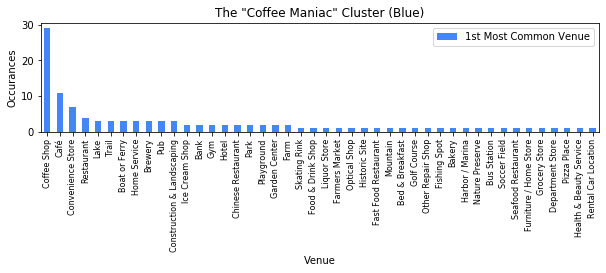

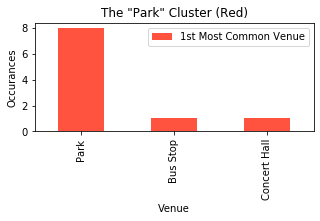

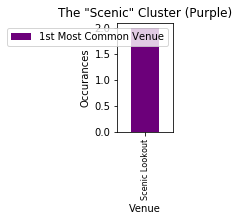

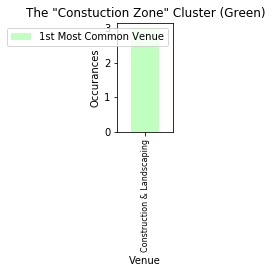

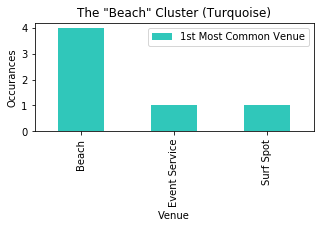

In [146]:
countclus1 = pd.DataFrame(cluster1['1st Most Common Venue'].value_counts())
countclus1.plot(kind='bar', figsize=(10, 2), rot=90, color = '#4287f5')
plt.xlabel('Venue')
plt.ylabel('Occurances')
plt.xticks(fontsize=8, rotation=90)
plt.title('The "Coffee Maniac" Cluster (Blue)')

countclus2 = pd.DataFrame(cluster2['1st Most Common Venue'].value_counts())
countclus2.plot(kind='bar', figsize=(5, 2), rot=90, color='#ff5340')
plt.xlabel('Venue')
plt.ylabel('Occurances')
plt.xticks(fontsize=10, rotation=90)
plt.title('The "Park" Cluster (Red)')

countclus3 = pd.DataFrame(cluster3['1st Most Common Venue'].value_counts())
countclus3.plot(kind='bar', figsize=(1, 2), rot=90, color='#6c007a')
plt.xlabel('Venue')
plt.ylabel('Occurances')
plt.xticks(fontsize=8, rotation=90)
plt.title('The "Scenic" Cluster (Purple)')

countclus4 = pd.DataFrame(cluster4['1st Most Common Venue'].value_counts())
countclus4.plot(kind='bar', figsize=(1, 2), rot=90, color='#c0ffbf')
plt.xlabel('Venue')
plt.ylabel('Occurances')
plt.xticks(fontsize=8, rotation=90)
plt.title('The "Constuction Zone" Cluster (Green)')

countclus5 = pd.DataFrame(cluster5['1st Most Common Venue'].value_counts())
countclus5.plot(kind='bar', figsize=(5, 2), rot=90, color='#30c7ba')
plt.xlabel('Venue')
plt.ylabel('Occurances')
plt.xticks(fontsize=10, rotation=90)
plt.title('The "Beach" Cluster (Turquoise)')
plt.show()

## III. Results

<p> In this project, I collected data on the neighbourhoods of Victoria, grabbed coordinates of each one, and grouped them based on venues I collected from FourSquare's API. The final graphs show the most popular venues on each cluster. A limitation to my report is the bias towards venues that Foursquare supplies, as it swings my dataset in favor of shops (coffee shop and store cluster has 30+ results, while the beaches cluster has 3 (Victoria is an island - there are way more than 3 beaches in the neighbourhoods given). Nonetheless, the dataset shows me that you should travel the lower Western side of the island, since it has the most neighbourhoods and venues clustered together in the smallest amount of space.</p>

## IV. Dicussion

<p>In the Northeast, you can follow the coast to hit the most shops, parks, and beaches. If I were to go to Victoria, I would travel along the outer coast of the island so that I can see the most in the smallest amount of time. For other individuals traveling to or who reside in Victoria, I would recommend the same. In conclusion, I would recommend that people travel the lower Northeast end of Victoria, and can refer to the graphs and maps created in this notebook to learn more.

As I mentioned in the results, my dataset is skewed in favor of shops, so if an individual wanted to learn more information about the natural beauty of Victoria, I would have to refer them to a different dataset, one that does not use FourSquare's API. </p>

## VII. Conclusion

<p>In conclusion, I have given visual geographic data about Victoria and the venues within each of its neighbourhoods with Python, machine learning, and Python's geographic modules. If someone was to travel to Victoria, I would recommend that they travel along the coast of the island so that they can see the get the most out of their journey. In that sense, they will be able to view the scenery, beaches, and shops, while still keeping it interesting and fun. 
    
If I were to go deeper into my research, I would use more than one API to get me datasets, and possible find a more accurate way to get geographic coordinates.</p>

## References

<p>Where Developers Learn, Share, &amp; Build Careers. (2020). Retrieved June 28, 2020, from <em>https://stackoverflow.com/</em>
    
    Read the Docs. (2020). Retrieved June 28, 2020, from <em>https://readthedocs.org/projects/matplotlib/</em>
    
    